In [1]:
import optuna
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import StandardScaler

np.random.seed(42)
random_state = 42

scaler = StandardScaler()
# 加载数据集
data_ssgsea = pd.read_csv('ssgsea_10.csv')
X_ssgsea = data_ssgsea.iloc[:, 1:]
y_ssgsea = data_ssgsea.iloc[:, 0]  # 假设标签在 data1 的第一列

X_ssgsea_scaled = scaler.fit_transform(X_ssgsea)

# 拆分数据集
X_train_ssgsea, X_test_ssgsea, y_train_ssgsea, y_test_ssgsea = train_test_split(X_ssgsea_scaled, y_ssgsea, test_size=0.2, random_state = random_state)

data_ppi = pd.read_csv('ppi_10.csv')
X_ppi = data_ppi.iloc[:, 1:]
y_ppi = data_ppi.iloc[:, 0]  # 假设标签在 data1 的第一列

X_ppi_scaled = scaler.fit_transform(X_ppi)

# 拆分数据集
X_train_ppi, X_test_ppi, y_train_ppi, y_test_ppi = train_test_split(X_ppi_scaled, y_ppi, test_size=0.2, random_state = random_state)

data_wgcna = pd.read_csv('wgcna_10.csv')
X_wgcna = data_wgcna.iloc[:, 1:]
y_wgcna = data_wgcna.iloc[:, 0]  # 假设标签在 data1 的第一列

X_wgcna_scaled = scaler.fit_transform(X_wgcna)

# 拆分数据集
X_train_wgcna, X_test_wgcna, y_train_wgcna, y_test_wgcna = train_test_split(X_wgcna_scaled, y_wgcna, test_size=0.2, random_state = random_state)

In [2]:
import joblib
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# 载入的基础模型
ssgsea = joblib.load('./basemodel/lda_ssgsea.joblib')
ppi = joblib.load('./basemodel/svm_ppi.joblib')
wgcna = joblib.load('./basemodel/rf_wgcna.joblib')

ssgsea.fit(X_train_ssgsea, y_train_ssgsea.squeeze())
ppi.fit(X_train_ppi, y_train_ppi.squeeze())
wgcna.fit(X_train_wgcna, y_train_wgcna.squeeze())

# 获取每个模型的预测概率
pred_ssgsea_train = ssgsea.predict_proba(X_train_ssgsea)[:, 1]
pred_ppi_train = ppi.predict_proba(X_train_ppi)[:, 1]
pred_wgcna_train = wgcna.predict_proba(X_train_wgcna)[:, 1]

pred_ssgsea_test = ssgsea.predict_proba(X_test_ssgsea)[:, 1]
pred_ppi_test = ppi.predict_proba(X_test_ppi)[:, 1]
pred_wgcna_test = wgcna.predict_proba(X_test_wgcna)[:, 1]



In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# 合并这几个预测概率作为新的特征矩阵
X_train = np.column_stack((pred_ssgsea_train, pred_ppi_train, pred_wgcna_train))
y_train = y_train_ssgsea.squeeze()

X_test = np.column_stack((pred_ssgsea_test, pred_ppi_test, pred_wgcna_test))
y_test = y_test_ssgsea.squeeze()


In [4]:
# 初始化逻辑回归模型
lr_model = LogisticRegression()

# 训练逻辑回归模型
lr_model.fit(X_train, y_train)

# 保存模型
joblib.dump(lr_model, 'meta_model.joblib')

# 用训练好的模型进行预测
y_pred_meta = lr_model.predict_proba(X_test)[:, 1]

# 计算AUC评分
auc_score = roc_auc_score(y_test, y_pred_meta)

print(f"逻辑回归模型的AUC评分：{auc_score}")

逻辑回归模型的AUC评分：0.9202898550724637


In [5]:
# 输出逻辑回归模型的系数和截距
print("逻辑回归模型的系数：", lr_model.coef_)
print("逻辑回归模型的截距：", lr_model.intercept_)

# 每个特征对应的系数
feature_names = ['ssgsea', 'ppi', 'wgcna']
for feature, coef in zip(feature_names, lr_model.coef_[0]):
    print(f"{feature} 的系数是: {coef}")

# 完整的决策函数
decision_function_values = lr_model.decision_function(X_test)
print("逻辑回归模型的决策函数值：", decision_function_values)

import numpy as np

# 计算每个特征的 OR
odds_ratios = np.exp(lr_model.coef_[0])

# 输出每个特征的 OR
for feature, odds_ratio in zip(feature_names, odds_ratios):
    print(f"{feature} 的OR是: {odds_ratio}")

逻辑回归模型的系数： [[1.48548521 1.6924608  4.41184184]]
逻辑回归模型的截距： [-3.63609996]
ssgsea 的系数是: 1.4854852132032155
ppi 的系数是: 1.6924608030333481
wgcna 的系数是: 4.4118418430179345
逻辑回归模型的决策函数值： [-0.1462306   1.45555909 -2.11734565 -1.66116946 -0.31273109 -0.86472465
 -0.55587413  0.29498139 -0.57740125 -0.16035511 -1.33585696 -0.47296053
 -0.62188732 -2.41638112 -1.70653967 -0.86633804  0.06837609 -1.52668247
 -1.35715523  1.16344677  0.05564051 -0.46213184  0.46934756 -1.09343371
 -0.96318263 -1.0869823  -0.18253435  0.51105387  0.79506583  0.32036314
 -0.38387052  0.10037047 -0.21276253 -0.28914136 -1.38392485]
ssgsea 的OR是: 4.417108132084408
ppi 的OR是: 5.432833402130043
wgcna 的OR是: 82.42113057173471


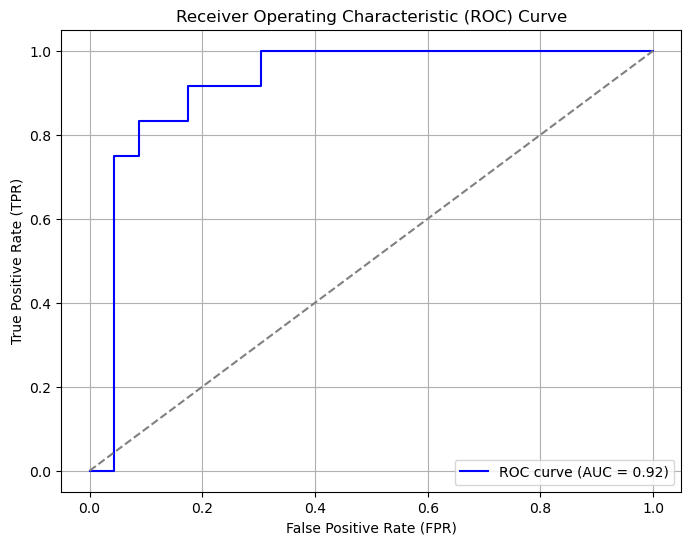

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 计算 ROC 曲线的假阳性率（FPR）、真阳性率（TPR）和阈值
fpr, tpr, thresholds = roc_curve(y_test, y_pred_meta)

# 计算 AUC（曲线下面积）
roc_auc = auc(fpr, tpr)

# 绘制 ROC 曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # 随机猜测的对角线
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


 model AUC: 0.9203


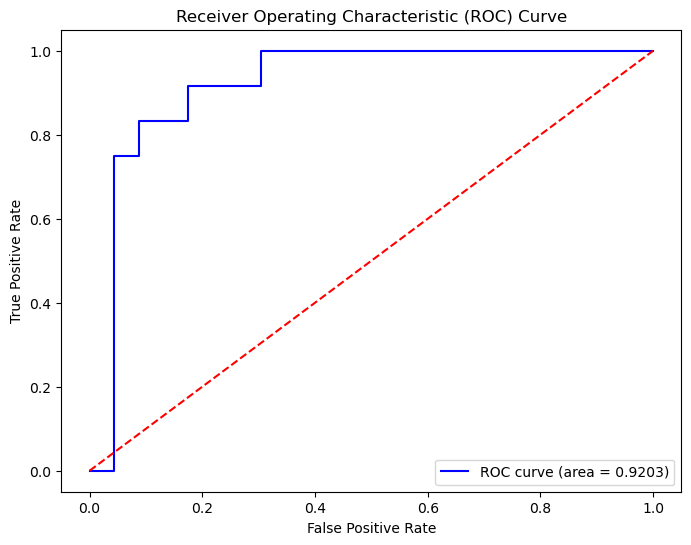

Accuracy: 0.8857142857142857
Precision: 0.9
AUC: 0.9202898550724637
召回率: 0.75
F1得分: 0.8181818181818182
Confusion Matrix: 
 [[22  1]
 [ 3  9]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.96      0.92        23
           1       0.90      0.75      0.82        12

    accuracy                           0.89        35
   macro avg       0.89      0.85      0.87        35
weighted avg       0.89      0.89      0.88        35



In [7]:
import joblib

### 导入一些库
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier as GBDT
from sklearn.ensemble import ExtraTreesClassifier as ET
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import AdaBoostClassifier as ADA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import StackingClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import (GradientBoostingClassifier, BaggingClassifier, 
                              AdaBoostClassifier, RandomForestClassifier, 
                              ExtraTreesClassifier)
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import (QuadraticDiscriminantAnalysis, 
                                           LinearDiscriminantAnalysis)
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import (GradientBoostingClassifier, BaggingClassifier, 
                              AdaBoostClassifier, RandomForestClassifier, 
                              ExtraTreesClassifier)
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import (QuadraticDiscriminantAnalysis, 
                                           LinearDiscriminantAnalysis)
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
# 绘制特征重要性图
import matplotlib.pyplot as plt
#建模调参
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,roc_curve
import numpy as np
np.random.seed(42)

X_val_meta = X_test
y_val_meta = y_test

pred_proba = lr_model.predict_proba(X_val_meta)[:, 1]
y_pred = lr_model.predict(X_val_meta)

# 计算准确率
accuracy = accuracy_score(y_val_meta, y_pred)
# 计算精确率
precision = precision_score(y_val_meta, y_pred)
# 计算AUC
auc = roc_auc_score(y_val_meta, pred_proba)
# 计算召回率
recall = recall_score(y_val_meta, y_pred)
# 计算F1得分
f1 = f1_score(y_val_meta, y_pred)
# 8. 计算 AUC 值
auc_value = roc_auc_score(y_val_meta, pred_proba)
print(f' model AUC: {auc_value:.4f}')

# 9. 计算 FPR 和 TPR
fpr, tpr, thresholds = roc_curve(y_val_meta, pred_proba)
# 10. 绘制 ROC 曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {auc_value:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # 对角线
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
print("Accuracy:", accuracy)
print("Precision:", precision)
print("AUC:", auc)
print("召回率:" ,recall)
print("F1得分:" ,f1)

print("Confusion Matrix: \n", metrics.confusion_matrix(y_val_meta, y_pred))  # 计算混淆矩阵
print("Classification Report: \n", metrics.classification_report(y_val_meta, y_pred))  # 计算分类报告




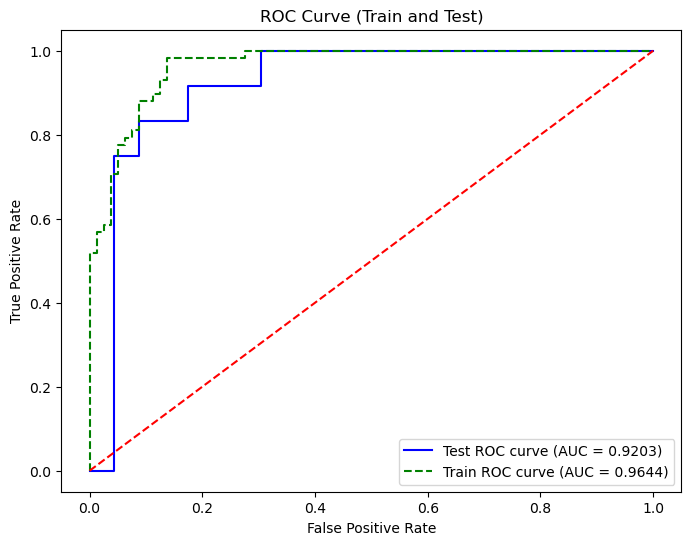

In [10]:
# 绘制训练集和测试集的ROC曲线
plt.figure(figsize=(8, 6))

# 绘制测试集 ROC 曲线
fpr, tpr, _ = roc_curve(y_test, pred_proba)
plt.plot(fpr, tpr, color='blue', label=f'Test ROC curve (AUC = {auc_value:.4f})')

# 绘制训练集 ROC 曲线，设置为虚线
fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_proba_train)
plt.plot(fpr_train, tpr_train, color='green', linestyle='--', label=f'Train ROC curve (AUC = {auc_train:.4f})')

# 对角线
plt.plot([0, 1], [0, 1], color='red', linestyle='--') 

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Train and Test)')
plt.legend(loc='lower right')
plt.show()


In [11]:
ssgsea = joblib.load('./basemodel/lda_ssgsea.joblib')
ppi = joblib.load('./basemodel/svm_ppi.joblib')
wgcna = joblib.load('./basemodel/rf_wgcna.joblib')
meta_model = joblib.load('./meta_model.joblib')

In [12]:
print(ssgsea)
print(ppi)
print(wgcna)
print(meta_model)

LinearDiscriminantAnalysis()
SVC(C=0.38995453773975636, probability=True, random_state=42)
RandomForestClassifier(max_depth=16, min_samples_split=19, n_estimators=240,
                       random_state=42)
LogisticRegression()


In [13]:
import optuna
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import StandardScaler

np.random.seed(42)
random_state = 42

scaler = StandardScaler()
# 加载数据集
data_ssgsea = pd.read_csv('ssgsea_10.csv')
X_ssgsea = data_ssgsea.iloc[:, 1:]
y_ssgsea = data_ssgsea.iloc[:, 0]  # 假设标签在 data1 的第一列

X_ssgsea_scaled = scaler.fit_transform(X_ssgsea)

# 拆分数据集
X_train_ssgsea, X_test_ssgsea, y_train_ssgsea, y_test_ssgsea = train_test_split(X_ssgsea_scaled, y_ssgsea, test_size=0.2, random_state = random_state)

data_ppi = pd.read_csv('ppi_10.csv')
X_ppi = data_ppi.iloc[:, 1:]
y_ppi = data_ppi.iloc[:, 0]  # 假设标签在 data1 的第一列

X_ppi_scaled = scaler.fit_transform(X_ppi)

# 拆分数据集
X_train_ppi, X_test_ppi, y_train_ppi, y_test_ppi = train_test_split(X_ppi_scaled, y_ppi, test_size=0.2, random_state = random_state)

data_wgcna = pd.read_csv('wgcna_10.csv')
X_wgcna = data_wgcna.iloc[:, 1:]
y_wgcna = data_wgcna.iloc[:, 0]  # 假设标签在 data1 的第一列

X_wgcna_scaled = scaler.fit_transform(X_wgcna)

# 拆分数据集
X_train_wgcna, X_test_wgcna, y_train_wgcna, y_test_wgcna = train_test_split(X_wgcna_scaled, y_wgcna, test_size=0.2, random_state = random_state)

ssgsea.fit(X_train_ssgsea, y_train_ssgsea.squeeze())
ppi.fit(X_train_ppi, y_train_ppi.squeeze())
wgcna.fit(X_train_wgcna, y_train_wgcna.squeeze())

 #预测概率和标签
y_pred_ssgsea = ssgsea.predict(X_test_ssgsea)
y_prob_ssgsea = ssgsea.predict_proba(X_test_ssgsea)[:, 1]

y_pred_ppi = ppi.predict(X_test_ppi)
y_prob_ppi = ppi.predict_proba(X_test_ppi)[:, 1]

y_pred_wgcna = wgcna.predict(X_test_wgcna)
y_prob_wgcna = wgcna.predict_proba(X_test_wgcna)[:, 1]





# 计算指标
def evaluate_model(y_test, y_pred, y_prob, model_name):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    
    print(f"{model_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")
    print("-" * 30)

# 评估各个模型
evaluate_model(y_test_ssgsea, y_pred_ssgsea, y_prob_ssgsea, "ssGSEA Model")
evaluate_model(y_test_ppi, y_pred_ppi, y_prob_ppi, "PPI Model")
evaluate_model(y_test_wgcna, y_pred_wgcna, y_prob_wgcna, "WGCNA Model")


ssGSEA Model Performance:
Accuracy: 0.6571
Precision: 0.5000
Recall: 0.4167
F1 Score: 0.4545
AUC: 0.7645
------------------------------
PPI Model Performance:
Accuracy: 0.7714
Precision: 1.0000
Recall: 0.3333
F1 Score: 0.5000
AUC: 0.8424
------------------------------
WGCNA Model Performance:
Accuracy: 0.7714
Precision: 0.6667
Recall: 0.6667
F1 Score: 0.6667
AUC: 0.8587
------------------------------


In [14]:
 #预测概率和标签
y_pred_ssgsea = ssgsea.predict(X_train_ssgsea)
y_prob_ssgsea = ssgsea.predict_proba(X_train_ssgsea)[:, 1]

y_pred_ppi = ppi.predict(X_train_ppi)
y_prob_ppi = ppi.predict_proba(X_train_ppi)[:, 1]

y_pred_wgcna = wgcna.predict(X_train_wgcna)
y_prob_wgcna = wgcna.predict_proba(X_train_wgcna)[:, 1]





# 计算指标
def evaluate_model(y_test, y_pred, y_prob, model_name):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    
    print(f"{model_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")
    print("-" * 30)

# 评估各个模型
evaluate_model(y_train_ssgsea, y_pred_ssgsea, y_prob_ssgsea, "ssGSEA Model")
evaluate_model(y_train_ppi, y_pred_ppi, y_prob_ppi, "PPI Model")
evaluate_model(y_train_wgcna, y_pred_wgcna, y_prob_wgcna, "WGCNA Model")

ssGSEA Model Performance:
Accuracy: 0.6957
Precision: 0.6667
Recall: 0.5517
F1 Score: 0.6038
AUC: 0.7584
------------------------------
PPI Model Performance:
Accuracy: 0.7174
Precision: 0.7714
Recall: 0.4655
F1 Score: 0.5806
AUC: 0.7869
------------------------------
WGCNA Model Performance:
Accuracy: 0.8913
Precision: 0.8909
Recall: 0.8448
F1 Score: 0.8673
AUC: 0.9625
------------------------------
